# Visualisation of 1D model output

**Date:** 2025-12-01

**Authors:** Damien Bouffard, Martin Schmid

**Summary:** This notebook provides tools to visualise 1D lake model output (Simstrat-like `T_out.dat`).

- `plot_temperature_heatmap(df, years=None, ...)` — plot temperature heatmap (depth vs time).
- `plot_temperature_at_depth(df, depth, ...)` — extract and plot a time series at the nearest available depth (with aggregation options).
- `plot_temperature_climatology(df, depth, ...)` — compute and plot daily-of-year climatology (mean, std, min, max) with optional baseline-year overlay.
- `compare_heatmaps(path1, path2, ...)` — load two site outputs and plot their difference heatmap (restricted to shallowest system).
- `plot_two_sites_at_depth(path1, path2, depth, ...)` — extract and plot aligned time series from two sites at a given depth.




In [43]:
# import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

In [44]:
# Load data
path = 'data/Geneva'
# Adjust the path - use the correct relative path from your notebook location
data_path = os.path.join(os.path.dirname(os.getcwd()), path, 'T_out.dat')

df = pd.read_csv(data_path)
df['Datetime'] = pd.Timestamp('1981-01-01') + pd.to_timedelta(df['Datetime'], unit='D')
df

,Datetime,-309.000,-308.000,-307.000,-306.000,-305.000,-304.000,-303.000,-302.000,-301.000,...,-9.000,-8.000,-7.000,-6.000,-5.000,-4.000,-3.000,-2.000,-1.000,-0.000
0,1981-01-02 01:00:02.880000000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,...,5.5154,5.5198,5.5242,5.5286,5.5330,5.5374,5.5418,5.5462,5.5506,5.5539
1,1981-01-02 04:00:02.879999999,4.5001,4.5001,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,4.5000,...,5.5152,5.5166,5.5155,5.5143,5.5124,5.5101,5.5072,5.5030,5.4950,5.4820
2,1981-01-02 07:00:02.880000000,4.5003,4.5002,4.5001,4.5001,4.5000,4.5000,4.5000,4.5000,4.5000,...,5.4946,5.4938,5.4925,5.4908,5.4887,5.4857,5.4826,5.4770,5.4682,5.4536
3,1981-01-02 10:00:02.880000000,4.5004,4.5002,4.5001,4.5001,4.5001,4.5000,4.5000,4.5000,4.5000,...,5.4727,5.4719,5.4709,5.4697,5.4683,5.4664,5.4640,5.4606,5.4542,5.4468
4,1981-01-02 13:00:02.880000000,4.5004,4.5003,4.5002,4.5001,4.5001,4.5001,4.5001,4.5000,4.5000,...,5.4658,5.4654,5.4647,5.4639,5.4627,5.4606,5.4584,5.4546,5.4480,5.4373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131195,2025-11-26 10:00:02.880000138,7.1850,7.1849,7.1848,7.1847,7.1847,7.1846,7.1846,7.1845,7.1845,...,10.3520,10.3520,10.3500,10.3490,10.3480,10.3460,10.3440,10.3410,10.3360,10.3290
131196,2025-11-26 13:00:02.880000138,7.1850,7.1849,7.1848,7.1847,7.1847,7.1846,7.1846,7.1845,7.1845,...,10.3460,10.3450,10.3440,10.3430,10.3420,10.3410,10.3390,10.3370,10.3340,10.3260
131197,2025-11-26 16:00:02.880000138,7.1850,7.1849,7.1848,7.1847,7.1847,7.1846,7.1846,7.1845,7.1845,...,10.3370,10.3360,10.3350,10.3340,10.3320,10.3300,10.3270,10.3240,10.3190,10.3130
131198,2025-11-26 19:00:02.880000138,7.1850,7.1849,7.1848,7.1847,7.1847,7.1846,7.1846,7.1846,7.1845,...,10.3200,10.3190,10.3170,10.3150,10.3130,10.3110,10.3090,10.3050,10.3010,10.2970


In [47]:
# Function to plot temperature heatmap
def plot_temperature_heatmap(df, years=None, cmap='viridis', vmin=None, vmax=None, figsize=(14,6), n_xticks=10, savepath=None):
    """Plot a temperature heatmap over depth and time.

    Parameters:
    - df: DataFrame with a `Datetime` column and depth columns (column names are numeric depths).
    - years: None (all data), int (single year), or (start, end) pair. start/end may be years (int) or datetime-like.
    - cmap, vmin, vmax, figsize: plotting options.
    - n_xticks: max number of x tick labels to show.
    - savepath: optional path to save the figure (PNG).
    Returns: matplotlib Axes object.
    """
    # Work on a copy to avoid side-effects
    d = df.copy()
    # Ensure Datetime column is datetime dtype
    if not np.issubdtype(d['Datetime'].dtype, np.datetime64):
        d['Datetime'] = pd.to_datetime(d['Datetime'])
    # Filter by years parameter
    start = None
    end = None
    if years is None:
        pass
    elif isinstance(years, int):
        d = d[d['Datetime'].dt.year == int(years)]
    elif isinstance(years, (list, tuple)) and len(years) == 2:
        a, b = years
        if isinstance(a, (int, np.integer)) and isinstance(b, (int, np.integer)):
            start = pd.Timestamp(f"{int(a)}-01-01")
            end = pd.Timestamp(f"{int(b)}-12-31")
        else:
            start = pd.to_datetime(a)
            end = pd.to_datetime(b)
        d = d[(d['Datetime'] >= start) & (d['Datetime'] <= end)]
    else:
        raise ValueError('`years` must be None, an int year, or a (start,end) pair')
    if d.empty:
        raise ValueError('No data available for the selected period')
    # Melt and pivot to heatmap-friendly format
    df_melted = d.melt(id_vars=['Datetime'], var_name='Depth (m)', value_name='Temperature')
    df_melted['Depth (m)'] = df_melted['Depth (m)'].astype(float) * -1
    heatmap_data = df_melted.pivot(index='Depth (m)', columns='Datetime', values='Temperature')
    heatmap_data = heatmap_data.sort_index(ascending=False)
    # Determine color limits if not provided
    arr = heatmap_data.values
    if vmin is None:
        vmin = np.nanpercentile(arr, 2)
    if vmax is None:
        vmax = np.nanpercentile(arr, 98)
    # Plot
    plt.figure(figsize=figsize)
    ax = sns.heatmap(heatmap_data, cmap=cmap, cbar_kws={'label': 'Temperature (°C)'}, vmin=vmin, vmax=vmax, xticklabels=False)
    # X-ticks: reduce density and format nicely
    if heatmap_data.shape[1] > 0:
        xticks_idx = np.linspace(0, heatmap_data.shape[1] - 1, min(n_xticks, heatmap_data.shape[1])).astype(int)
        ax.set_xticks(xticks_idx)
        ax.set_xticklabels([heatmap_data.columns[i].strftime('%Y-%m-%d') for i in xticks_idx], rotation=45, ha='right')
    # Labels & title
    ax.set_xlabel('Date')
    ax.set_ylabel('Depth (m)')
    if years is None:
        title_period = 'All data'
    elif isinstance(years, int):
        title_period = str(years)
    else:
        if start is None:
            start = pd.to_datetime(years[0])
            end = pd.to_datetime(years[1])
        title_period = f"{start.date()} to {end.date()}"
    ax.set_title(f'Temperature  ({title_period})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    return ax


# Example usage (uncomment to run):
# plot_temperature_heatmap(df)                       # plot all data
# plot_temperature_heatmap(df, years=2024)           # single year
# plot_temperature_heatmap(df, years=(2020,2022))    # time period from 2020 to 2022

In [50]:
# Function to plot temperature time series at a given depth
def plot_temperature_at_depth(df, depth, agg='daily', method='mean', figsize=(12,4), savepath=None):
    """Plot temperature time series at the nearest available depth with optional aggregation.

    This version robustly finds numeric depth columns from the original DataFrame (avoids
    ambiguities introduced by melting or sign conventions) and matches the nearest depth
    by absolute difference. `depth` is expected as a positive number (metres below surface).

    Parameters:
    - df: DataFrame with a `Datetime` column and depth columns (column names numeric or string representing depth in metres).
    - depth: numeric target depth (positive value, metres). The function finds the nearest depth column.
    - agg: 'daily', 'monthly', 'yearly' or pandas-style freq codes 'D','M','Y'. If None, no aggregation.
    - method: aggregation method: 'mean' or 'median'.
    - figsize: figure size tuple.
    - savepath: optional path to save the figure (PNG).
    Returns: matplotlib Axes object.
    """
    d = df.copy()
    # Ensure Datetime dtype
    if not np.issubdtype(d['Datetime'].dtype, np.datetime64):
        d['Datetime'] = pd.to_datetime(d['Datetime'])
    # Identify candidate depth columns (everything except 'Datetime')
    candidate_cols = [c for c in d.columns if str(c).lower() != 'datetime']
    if not candidate_cols:
        raise ValueError('No depth columns found in dataframe')
    # Try to parse numeric depths from column names
    depth_values = {}  # mapping col -> numeric depth (absolute, positive)
    for c in candidate_cols:
        # try direct conversion first
        try:
            val = float(c)
        except Exception:
            # fallback: extract first numeric token from the column name
            s = str(c)
            import re
            m = re.search(r'([-+]?[0-9]*\.?[0-9]+)', s)
            if m:
                try:
                    val = float(m.group(1))
                except Exception:
                    val = None
            else:
                val = None
        if val is not None and not np.isnan(val):
            depth_values[c] = abs(val)  # treat depth as positive magnitude
    if not depth_values:
        raise ValueError('Unable to parse any numeric depth from column names')
    # Find nearest available depth (compare absolute distances)
    requested = float(depth)
    cols = np.array(list(depth_values.keys()))
    vals = np.array(list(depth_values.values()))
    idx = np.argmin(np.abs(vals - requested))
    selected_col = cols[idx]
    selected_depth = vals[idx]
    # Build time series from selected column (preserve original sign/values)
    ts = d.set_index('Datetime')[selected_col].sort_index()
    ts = ts.dropna()
    if ts.empty:
        raise ValueError(f'No data available at selected depth column {selected_col}')
    # If agg is None, plot raw timeseries (but still allow method ignored)
    agg_map = {'daily':'D','monthly':'M','yearly':'Y','D':'D','M':'M','Y':'Y'}
    if agg is None:
        ts_agg = ts
    else:
        if agg not in agg_map:
            raise ValueError("`agg` must be one of 'daily','monthly','yearly' or 'D','M','Y' or None")
        freq = agg_map[agg]
        if method == 'mean':
            ts_agg = ts.resample(freq).mean()
        elif method == 'median':
            ts_agg = ts.resample(freq).median()
        else:
            raise ValueError("`method` must be 'mean' or 'median'")
    # Plot
    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=ts_agg.index, y=ts_agg.values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'Temperature at depth ~{selected_depth} m')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    if savepath:
        # ensure directory exists
        os.makedirs(os.path.dirname(savepath), exist_ok=True) if os.path.dirname(savepath) else None
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    return ax

# Examples:
# plot_temperature_at_depth(df, depth=1.0, agg='daily')
# plot_temperature_at_depth(df, depth=50, agg='monthly', method='median')

<Axes: title={'center': 'Temperature  (2020-01-01 to 2022-12-31)'}, xlabel='Date', ylabel='Depth (m)'>

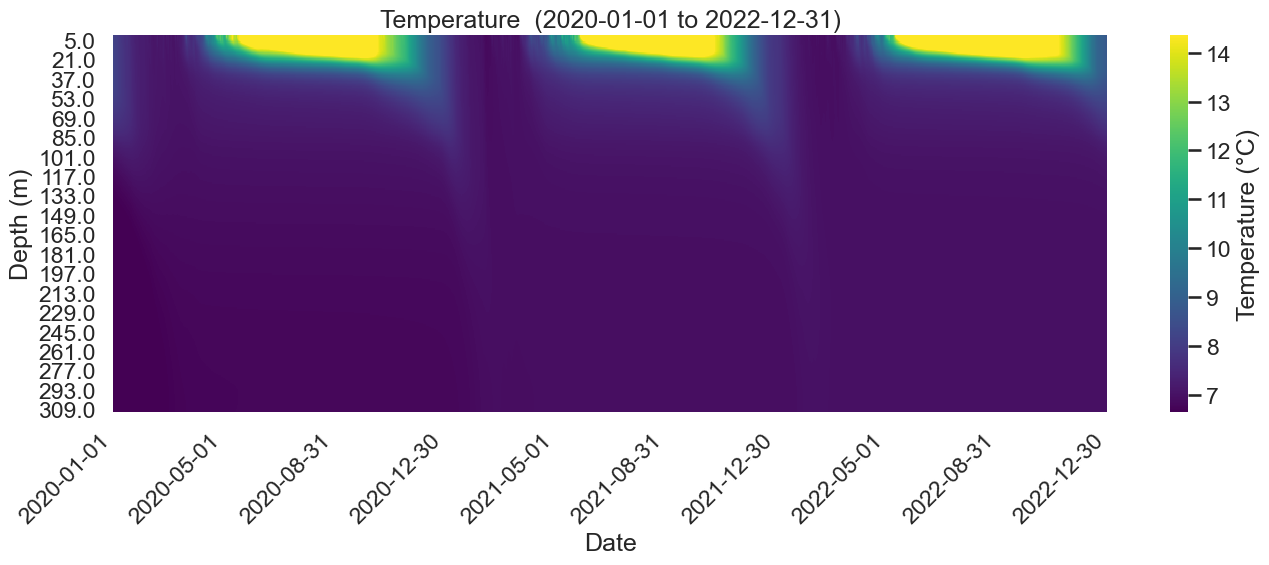

In [49]:
# Example usage (uncomment to run):
#plot_temperature_heatmap(df)                       # plot all data
# plot_temperature_heatmap(df, years=2024)           # single year
plot_temperature_heatmap(df, years=(2020,2022))    # time period from 2020 to 2022

/var/folders/bz/6fwq95z91450fyw8y89913_w0000gr/T/ipykernel_69423/697029568.py:69: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts_agg = ts.resample(freq).mean()


<Axes: title={'center': 'Temperature at depth ~0.0 m'}, xlabel='Date', ylabel='Temperature (°C)'>

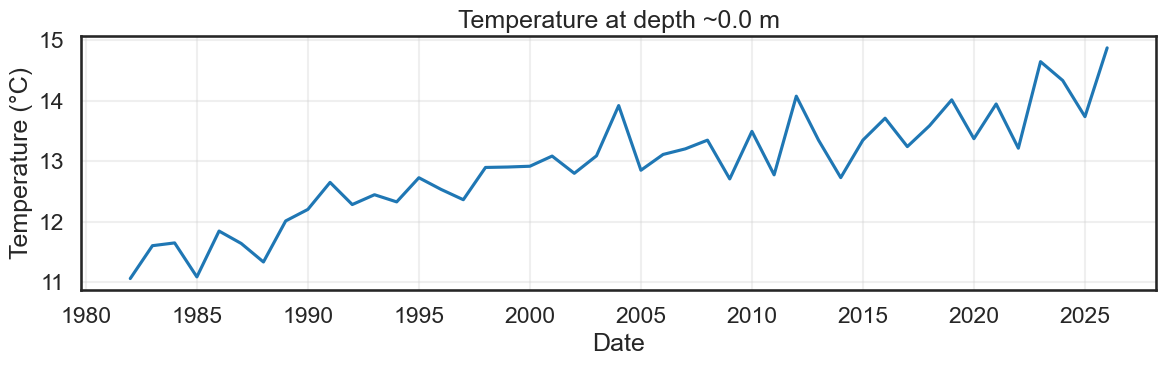

In [51]:
# Example usage:
# plot_temperature_at_depth(df, depth=1.0, agg='daily')
plot_temperature_at_depth(df, depth=0, agg='yearly', method='mean')

In [52]:
# Function to plot daily-of-year climatology at a given depth
def plot_temperature_climatology(df, depth, period=None, baseline_year=None, method='mean', figsize=(12,5), savepath=None):
    """Compute and plot daily-of-year climatology at nearest depth.

    - df: DataFrame with `Datetime` column and depth columns (column names numeric or containing numeric depth).
    - depth: target positive depth (m). Nearest available depth column is used.
    - period: None (all years) or (start_year, end_year) or list of years to include in climatology.
    - baseline_year: optional int year to overlay as a line (will be aligned to day-of-year axis Jan1-Dec31).
    - method: aggregation method across years for each day: 'mean' or 'median' (used for climatology center).
    - figsize, savepath: plotting options.
    Returns: (ax, climatology_df) where climatology_df has columns ['mean','std','min','max','count'] indexed by dayofyear (1..365).
    """
    d = df.copy()
    if not np.issubdtype(d['Datetime'].dtype, np.datetime64):
        d['Datetime'] = pd.to_datetime(d['Datetime'])
    # Identify depth column (reuse robust parsing used previously)
    candidate_cols = [c for c in d.columns if str(c).lower() != 'datetime']
    if not candidate_cols:
        raise ValueError('No depth columns found in dataframe')
    depth_values = {}
    import re
    for c in candidate_cols:
        try:
            val = float(c)
        except Exception:
            s = str(c)
            m = re.search(r'([-+]?[0-9]*\.?[0-9]+)', s)
            if m:
                try:
                    val = float(m.group(1))
                except Exception:
                    val = None
            else:
                val = None
        if val is not None and not np.isnan(val):
            depth_values[c] = abs(val)
    if not depth_values:
        raise ValueError('Unable to parse any numeric depth from column names')
    requested = float(depth)
    cols = np.array(list(depth_values.keys()))
    vals = np.array(list(depth_values.values()))
    idx = np.argmin(np.abs(vals - requested))
    selected_col = cols[idx]
    selected_depth = vals[idx]
    # Build time series for selected column
    ts = d.set_index('Datetime')[selected_col].sort_index()
    # Optionally filter period for climatology calculation
    if period is not None:
        if isinstance(period, (list, tuple)) and len(period) == 2 and all(isinstance(x, int) for x in period):
            start = pd.Timestamp(f"{int(period[0])}-01-01")
            end = pd.Timestamp(f"{int(period[1])}-12-31")
            ts = ts[(ts.index >= start) & (ts.index <= end)]
        elif isinstance(period, (list, tuple)) and all(isinstance(x, int) for x in period):
            ts = ts[ts.index.year.isin(period)]
        elif isinstance(period, int):
            ts = ts[ts.index.year == int(period)]
        else:
            raise ValueError('`period` must be None, int year, (start,end) ints, or list of years')
    if ts.dropna().empty:
        raise ValueError('No data available for selected depth/period')
    # Remove Feb 29 to have consistent 365-day climatology
    ts = ts[~((ts.index.month == 2) & (ts.index.day == 29))]
    # Build dataframe with day-of-year and temperature
    df_days = pd.DataFrame({'Datetime': ts.index, 'Temperature': ts.values})
    df_days['doy'] = df_days['Datetime'].dt.dayofyear
    # Group by day of year and compute stats across years (for each calendar day)
    if method == 'mean':
        grp = df_days.groupby('doy')['Temperature'].agg(['mean','std','min','max','count'])
    elif method == 'median':
        grp = df_days.groupby('doy')['Temperature'].agg(['median','std','min','max','count']).rename(columns={'median':'mean'})
    else:
        raise ValueError("`method` must be 'mean' or 'median'")
    # Ensure index covers 1..365 (fill missing days with NaNs)
    all_doys = pd.Index(np.arange(1,366), name='doy')
    climatology = grp.reindex(all_doys)
    # Prepare x-axis as a dummy non-leap year dates for plotting (use 2001) covering Jan 1 -> Dec 31
    x_dates = pd.date_range('2001-01-01', periods=365, freq='D')
    # Plot climatology
    plt.figure(figsize=figsize)
    ax = plt.gca()
    # Convert climatology columns to arrays for plotting (keep NaNs)
    mean_arr = climatology['mean'].values
    std_arr = climatology['std'].values
    min_arr = climatology['min'].values
    max_arr = climatology['max'].values
    # Min-max shaded area (handle NaNs)
    ax.fill_between(x_dates, min_arr, max_arr, color='lightgray', alpha=0.5, label='min-max')
    # Mean ± std shaded area (darker)
    ax.fill_between(x_dates, mean_arr - std_arr, mean_arr + std_arr, color='steelblue', alpha=0.3, label='mean ± std')
    # Mean line
    ax.plot(x_dates, mean_arr, color='navy', lw=2, label=f'{method} climatology')
    # Optionally overlay baseline year aligned to day-of-year Jan1-Dec31
    if baseline_year is not None:
        by = int(baseline_year)
        ts_by = ts[ts.index.year == by].resample('D').mean()
        # remove Feb29 if present
        ts_by = ts_by[~((ts_by.index.month == 2) & (ts_by.index.day == 29))]
        if ts_by.empty:
            raise ValueError(f'No data available for baseline year {by}')
        # Reindex baseline series onto full-day-of-year 1..365 (so plotting aligns Jan1..Dec31)
        ts_by_df = pd.DataFrame({'Datetime': ts_by.index, 'Temperature': ts_by.values})
        ts_by_df['doy'] = ts_by_df['Datetime'].dt.dayofyear
        baseline_series = ts_by_df.set_index('doy').reindex(all_doys)['Temperature'].values
        ax.plot(x_dates, baseline_series, color='crimson', lw=1.5, label=str(by))
    # Formatting and ensure x-axis spans Jan 1 -> Dec 31
    ax.set_xlabel('Day of year')
    ax.set_ylabel('Temperature (°C)')
    title_period = 'all years' if period is None else (str(period) if not isinstance(period, (list, tuple)) else f'{period[0]}-{period[-1]}')
    ax.set_title(f'Climatology at ~{selected_depth} m — period: {title_period}')
    # Month ticks at start of each month
    months = pd.date_range('2001-01-01', periods=12, freq='MS')
    ax.set_xticks(months)
    ax.set_xticklabels([m.strftime('%b') for m in months])
    # Force x-limits to Jan 1 and Dec 31 of the dummy year so plot always starts/ends on those dates
    ax.set_xlim([x_dates[0], x_dates[-1]])
    ax.grid(alpha=0.25)
    ax.legend()
    plt.tight_layout()
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True) if os.path.dirname(savepath) else None
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    return ax, climatology

# Example usage:
# ax, clim = plot_temperature_climatology(df, depth=0, period=(1981,2024), baseline_year=2012, method='mean')

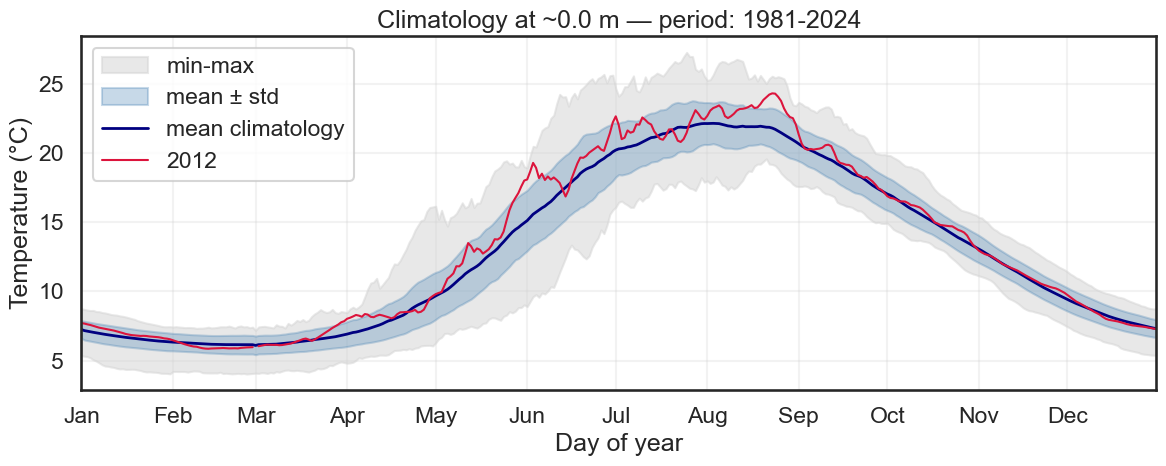

In [53]:
# Example usage:
ax, clim = plot_temperature_climatology(df, depth=0, period=(1981,2024), baseline_year=2012, method='mean')

In [ ]:
# Function to compare two heatmaps and plot their difference
def compare_heatmaps(path1, path2, years=None, cmap='RdBu_r', figsize=(14,6), n_xticks=10, savepath=None):
    """Load two `T_out.dat` datasets from folders `path1` and `path2`, build heatmaps and plot their difference.

    Comparison is restricted vertically to the maximum depth of the shallower system (by magnitude).
    Only overlapping depths and times are used to compute the difference to avoid large NaN areas.

    - path1, path2: relative folders under the repository (e.g. 'data/Geneva').
    - years: None, int, or (start,end) pair to filter both datasets before computing heatmaps.
    - cmap: diverging colormap for difference (default 'RdBu_r').
    - n_xticks, figsize: plotting options.
    - savepath: optional path to save the figure PNG.
    Returns: (ax, diff_heatmap)
    """
    def load_heatmap(path, years):
        p = os.path.join(os.path.dirname(os.getcwd()), path, 'T_out.dat')
        df_local = pd.read_csv(p)
        df_local['Datetime'] = pd.Timestamp('1981-01-01') + pd.to_timedelta(df_local['Datetime'], unit='D')
        if years is not None:
            if isinstance(years, int):
                df_local = df_local[df_local['Datetime'].dt.year == int(years)]
            elif isinstance(years, (list,tuple)) and len(years) == 2:
                a,b = years
                if isinstance(a, int) and isinstance(b, int):
                    start = pd.Timestamp(f"{int(a)}-01-01"); end = pd.Timestamp(f"{int(b)}-12-31")
                else:
                    start = pd.to_datetime(a); end = pd.to_datetime(b)
                df_local = df_local[(df_local['Datetime'] >= start) & (df_local['Datetime'] <= end)]
            else:
                raise ValueError('`years` must be None, an int year, or a (start,end) pair')
        # Melt and convert depth labels to numeric (extract numeric token)
        df_m = df_local.melt(id_vars=['Datetime'], var_name='Depth', value_name='Temperature')
        df_m['Depth'] = pd.to_numeric(df_m['Depth'].astype(str).str.extract(r'([-+]?[0-9]*\.?[0-9]+)')[0], errors='coerce')
        df_m = df_m.dropna(subset=['Depth'])
        # Use depth magnitude as positive (0 = surface, larger = deeper) for plotting
        df_m['Depth_mag'] = df_m['Depth'].astype(float).abs()
        df_m['Depth_plot'] = df_m['Depth_mag']
        heat = df_m.pivot(index='Depth_plot', columns='Datetime', values='Temperature')
        # Sort depths ascending so surface (smallest depth) is first row (top) with default heatmap origin='upper'
        heat = heat.sort_index(ascending=True)
        return heat
    # Load both heatmaps
    h1 = load_heatmap(path1, years)
    h2 = load_heatmap(path2, years)
    if h1.empty or h2.empty:
        raise ValueError('One of the heatmaps is empty after loading/filtering')
    # Compute maximum depths (by magnitude) available in each (positive numbers)
    max1 = np.nanmax(h1.index.values) if h1.shape[0] > 0 else 0
    max2 = np.nanmax(h2.index.values) if h2.shape[0] > 0 else 0
    shallow_max = min(max1, max2)
    # Restrict to depths within the shallowest system's max depth
    depths1 = np.array(h1.index)
    depths2 = np.array(h2.index)
    depths_in_range1 = [d for d in depths1 if d <= shallow_max]
    depths_in_range2 = [d for d in depths2 if d <= shallow_max]
    # Find overlapping depths (intersection) to avoid NaNs from missing rows
    depths_common = sorted(list(set(depths_in_range1).intersection(set(depths_in_range2))), reverse=False)
    if not depths_common:
        # fallback to union within range if intersection is empty
        depths_common = sorted(list(set(depths_in_range1).union(set(depths_in_range2))), reverse=False)
    # Find overlapping time columns (intersection) to ensure comparable columns
    times_common = sorted(list(set(h1.columns).intersection(set(h2.columns))))
    if not times_common:
        raise ValueError('No overlapping datetime columns between the two datasets')
    # Reindex heatmaps to the selected common depths and times
    h1c = h1.reindex(index=depths_common, columns=times_common)
    h2c = h2.reindex(index=depths_common, columns=times_common)
    # Compute difference (h1 - h2)
    diff = h1c - h2c
    # Symmetric color limits around zero
    arr = diff.values
    if np.all(np.isnan(arr)):
        raise ValueError('Difference matrix is all NaN (no overlapping data after intersection)')
    absmax = np.nanmax(np.abs(arr))
    vmin = -absmax; vmax = absmax
    # Ensure depth index sorted ascending (surface at top with default origin)
    diff = diff.sort_index(ascending=True)
    # Plot difference heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(diff, cmap=cmap, center=0, vmin=vmin, vmax=vmax, cbar_kws={'label':'Temperature difference (°C)'}, xticklabels=False)
    # X-tick formatting: reduce density and format dates
    if diff.shape[1] > 0:
        xticks_idx = np.linspace(0, diff.shape[1]-1, min(n_xticks, diff.shape[1])).astype(int)
        ax.set_xticks(xticks_idx)
        ax.set_xticklabels([diff.columns[i].strftime('%Y-%m-%d') for i in xticks_idx], rotation=45, ha='right')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Date')
    ax.set_title(f'Difference heatmap: {path1} minus {path2} (depths ≤ {shallow_max} m)')
    # No invert_yaxis: index sorted ascending (smallest depth first) so surface at top
    plt.tight_layout()
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True) if os.path.dirname(savepath) else None
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    return ax, diff

# Example usage:
#compare_heatmaps('data/Geneva', 'data/Upper_Lugano', years=(1981, 2024)) 

(<Axes: title={'center': 'Difference heatmap: data/Geneva minus data/Upper_Lugano (depths ≤ 287.0 m)'}, xlabel='Datetime', ylabel='Depth (m)'>,
 Datetime    1981-01-02 01:00:02.880000000  1981-01-02 04:00:02.879999999  \
 Depth_plot                                                                 
 0.0                                   0.0                         0.0046   
 1.0                                   0.0                         0.0089   
 2.0                                   0.0                         0.0118   
 3.0                                   0.0                         0.0133   
 4.0                                   0.0                         0.0144   
 ...                                   ...                            ...   
 283.0                                 0.0                         0.0000   
 284.0                                 0.0                         0.0000   
 285.0                                 0.0                         0.0000   
 286.0   

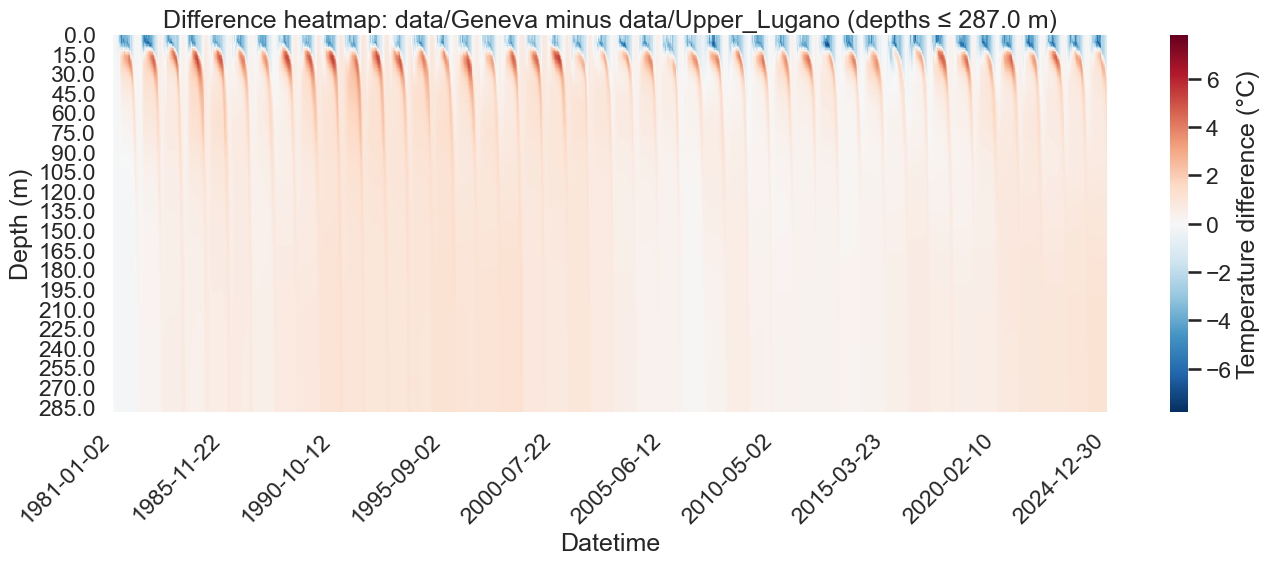

In [39]:
compare_heatmaps('data/Geneva', 'data/Upper_Lugano', years=(1981, 2024))         # single year

In [56]:
# Function to plot temperature time series from two sites at a given depth
def plot_two_sites_at_depth(path1, path2, depth, years=None, agg='daily', method='mean', figsize=(12,4), savepath=None):
    """Plot temperature time series from two `T_out.dat` files at the nearest available depth.

    - path1, path2: relative folders (e.g. 'data/Geneva').
    - depth: target positive depth (m).
    - years: None, int, or (start,end) pair to filter both datasets before extracting series.
    - agg: 'daily','monthly','yearly' or 'D','M','Y' or None for no aggregation.
    - method: 'mean' or 'median' used when aggregating.
    - savepath: optional path to save the figure.
    Returns: (ax, df_combined) where df_combined has two columns with aligned times.
    """
    def load_series(path, years):
        p = os.path.join(os.path.dirname(os.getcwd()), path, 'T_out.dat')
        df_local = pd.read_csv(p)
        df_local['Datetime'] = pd.Timestamp('1981-01-01') + pd.to_timedelta(df_local['Datetime'], unit='D')
        if years is not None:
            if isinstance(years, int):
                df_local = df_local[df_local['Datetime'].dt.year == int(years)]
            elif isinstance(years, (list,tuple)) and len(years) == 2:
                a,b = years
                if isinstance(a, int) and isinstance(b, int):
                    start = pd.Timestamp(f"{int(a)}-01-01"); end = pd.Timestamp(f"{int(b)}-12-31")
                else:
                    start = pd.to_datetime(a); end = pd.to_datetime(b)
                df_local = df_local[(df_local['Datetime'] >= start) & (df_local['Datetime'] <= end)]
            else:
                raise ValueError('`years` must be None, an int year, or a (start,end) pair')
        # Identify numeric depth columns from column names
        candidate_cols = [c for c in df_local.columns if str(c).lower() != 'datetime']
        depth_values = {}
        import re
        for c in candidate_cols:
            try:
                val = float(c)
            except Exception:
                s = str(c)
                m = re.search(r'([-+]?[0-9]*\.?[0-9]+)', s)
                if m:
                    try:
                        val = float(m.group(1))
                    except Exception:
                        val = None
                else:
                    val = None
            if val is not None and not np.isnan(val):
                depth_values[c] = abs(val)
        if not depth_values:
            raise ValueError(f'No numeric depth columns found in {path}')
        # choose nearest column by absolute depth
        cols = np.array(list(depth_values.keys()))
        vals = np.array(list(depth_values.values()))
        idx = np.argmin(np.abs(vals - float(depth)))
        selected_col = cols[idx]
        selected_depth = vals[idx]
        # extract series
        s = df_local.set_index('Datetime')[selected_col].sort_index()
        s.name = os.path.basename(path.rstrip('/'))
        return s, selected_col, selected_depth
    # Load both series
    s1, col1, d1 = load_series(path1, years)
    s2, col2, d2 = load_series(path2, years)
    # Aggregation mapping
    agg_map = {'daily':'D','monthly':'M','yearly':'Y','D':'D','M':'M','Y':'Y', None: None}
    if agg not in agg_map:
        raise ValueError("`agg` must be one of 'daily','monthly','yearly','D','M','Y' or None")
    freq = agg_map[agg]
    if freq is not None:
        if method == 'mean':
            s1 = s1.resample(freq).mean()
            s2 = s2.resample(freq).mean()
        elif method == 'median':
            s1 = s1.resample(freq).median()
            s2 = s2.resample(freq).median()
        else:
            raise ValueError("`method` must be 'mean' or 'median'")
    # Align on union of times (so both series share same index)
    df_combined = pd.concat([s1, s2], axis=1)
    # Plot both series
    plt.figure(figsize=figsize)
    ax = plt.gca()
    if df_combined.shape[0] == 0:
        raise ValueError('No overlapping data to plot after processing')
    ax.plot(df_combined.index, df_combined.iloc[:,0], label=f"{s1.name} ")
    ax.plot(df_combined.index, df_combined.iloc[:,1], label=f"{s2.name} ")
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'Temperature at depth ~{depth} m: {os.path.basename(path1)} vs {os.path.basename(path2)}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True) if os.path.dirname(savepath) else None
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    return ax, df_combined

# Example usage:
# ax, df = plot_two_sites_at_depth('data/Geneva', 'data/Upper_Lugano', depth=10, years=(2000,2020), agg='monthly', savepath='figures/compare_10m.png')

/var/folders/bz/6fwq95z91450fyw8y89913_w0000gr/T/ipykernel_69423/2570127408.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s1 = s1.resample(freq).mean()
/var/folders/bz/6fwq95z91450fyw8y89913_w0000gr/T/ipykernel_69423/2570127408.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s2 = s2.resample(freq).mean()


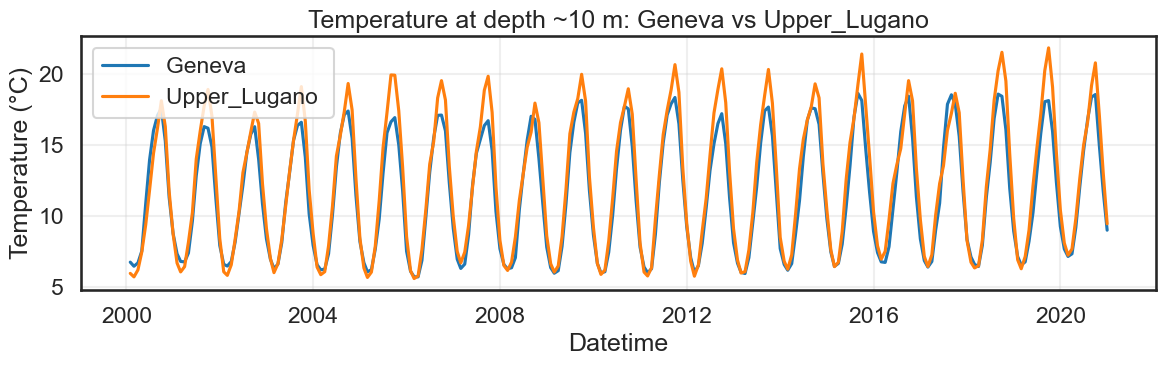

In [57]:
# Example usage:
ax, df = plot_two_sites_at_depth('data/Geneva', 'data/Upper_Lugano', depth=10, years=(2000,2020), agg='monthly', savepath='figures/compare_10m.png')